In [1]:
#!pip install pymc

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

In [3]:
train = pd.read_csv('train_clf.csv')
test = pd.read_csv('test_clf.csv')

In [4]:
test

,a,b,c
0,6.106970,8.712798,-1.523174
1,5.796587,10.704556,-3.947281
2,6.041652,6.628682,0.602950
3,2.201992,1.272898,1.716670
4,4.501528,3.148547,2.082501
...,...,...,...
95,1.535907,5.895946,-3.239022
96,5.623099,1.351693,4.804637
97,7.483925,3.173440,5.189085
98,9.061999,8.862560,1.132715


In [5]:
train.head(26)

,a,b,c,y
0,6.061051,8.085120,-0.901515,0.0
1,8.625052,9.712480,0.410613,0.0
2,1.705775,0.676360,1.823731,1.0
3,2.170837,1.363792,1.311898,1.0
4,0.467688,1.271315,0.085517,1.0
5,3.169000,1.365637,2.715916,1.0
6,9.931298,6.548447,4.672355,0.0
7,8.173714,11.380911,-2.037787,0.0
8,2.193545,3.047922,-0.013167,1.0
9,0.637349,5.785716,-4.163494,1.0


In [6]:
X_train = train[['a', 'b', 'c']].values
y_train = train['y'].values

In [7]:
X_train.shape

(100, 3)

In [8]:
train_features = train[['a', 'b', 'c']]
train_labels = train['y']
test_features = test[['a', 'b', 'c']]

train_features_centered = train_features - train_features.mean()
test_features_centered = test_features - train_features.mean()

In [9]:
with pm.Model() as model_1:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=20)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=3)

    mu = alpha_tmp + pm.math.dot(train_features_centered, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    feature_mean = pm.math.dot(beta, train_features_centered.mean(axis=0))
    alpha = pm.Deterministic('alpha', alpha_tmp - feature_mean)
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('yl', p=theta, observed=train_labels)

    trace_1 = pm.sample(1000, tune=2000, chains=4, cores=4, target_accept=0.95)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tmp, beta]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [10]:
with model_1:
    ppc = pm.sample_posterior_predictive(trace_1, var_names=['yl'])

Sampling: [yl]


In [11]:
with model_1:
    ppc1 = pm.sample_posterior_predictive(trace_1, var_names=['theta'])

Sampling: []


In [12]:
posterior_1 = trace_1.posterior.stack(samples=("chain", "draw"))

posterior_1['theta'].values.T

array([[1.49851961e-03, 2.95905436e-06, 9.99980060e-01, ...,
        4.30318629e-04, 9.98768054e-01, 8.62459558e-01],
       [9.29626971e-04, 9.61550519e-07, 9.99992194e-01, ...,
        2.35883243e-04, 9.99244042e-01, 8.55024412e-01],
       [7.73202527e-04, 8.72881375e-07, 9.99995711e-01, ...,
        1.97915908e-04, 9.99231038e-01, 7.74250025e-01],
       ...,
       [5.14089023e-10, 5.66209469e-18, 1.00000000e+00, ...,
        1.26641471e-11, 9.99999995e-01, 9.83443815e-01],
       [5.37859797e-11, 7.61140987e-20, 1.00000000e+00, ...,
        8.71093155e-13, 9.99999999e-01, 9.54523726e-01],
       [1.51479575e-05, 1.68000308e-09, 9.99999972e-01, ...,
        2.36331162e-06, 9.99942704e-01, 7.83777125e-01]])

In [13]:
def classify(X, threshold):
    """
    Моя классификационная функция
    """
    X = np.array(X)
    μ = posterior_1['alpha'].mean().values + posterior_1['beta'].mean().values * X
    prob = 1 / (1 + np.exp(-μ))
    return prob, np.where(prob >= threshold,1,0)

classify(test[['a', 'b', 'c']], 0.5)

(array([[3.65854635e-05, 6.83202499e-07, 8.08447345e-01],
        [5.87780815e-05, 3.25960073e-08, 9.94193812e-01],
        [4.04241557e-05, 1.64892088e-05, 1.40891499e-01],
        [1.40553806e-02, 5.56552299e-02, 2.90510408e-02],
        [4.24847175e-04, 3.34630066e-03, 1.68226853e-02],
        [6.89124184e-03, 1.06318872e-02, 1.46202627e-02],
        [7.78837661e-07, 4.01666949e-04, 5.58152648e-05],
        [5.47246847e-02, 1.50565547e-01, 1.64042805e-02],
        [8.65289042e-04, 1.45228500e-03, 2.85248745e-02],
        [6.95111091e-06, 4.84858883e-07, 4.81018366e-01],
        [2.40038670e-04, 2.20027250e-06, 9.08016599e-01],
        [3.70447506e-03, 1.10500001e-01, 4.28219553e-03],
        [4.99955604e-02, 6.49055748e-06, 9.98146451e-01],
        [3.12792815e-08, 2.19865646e-06, 1.52800002e-03],
        [2.07780696e-02, 6.72922990e-02, 2.55183024e-02],
        [9.85139111e-02, 3.09966804e-03, 7.84971023e-01],
        [7.77937761e-06, 5.04086702e-09, 9.94904677e-01],
        [3.785

/Users/imachome/anaconda3/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


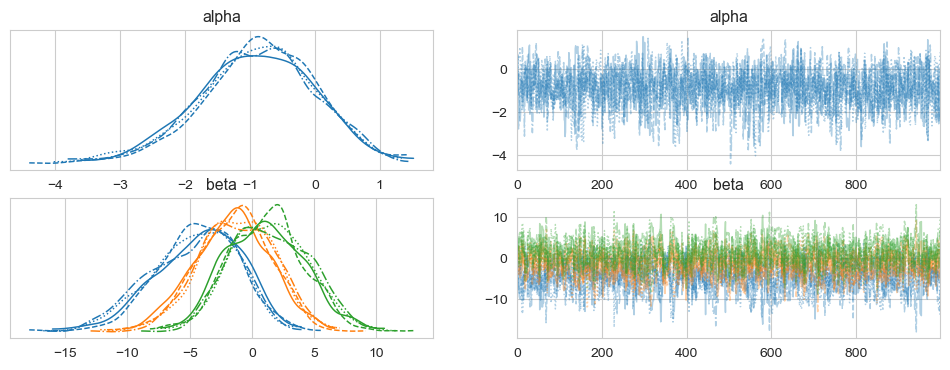

In [14]:
az.plot_trace(trace_1, var_names = ['alpha','beta'],compact=True);

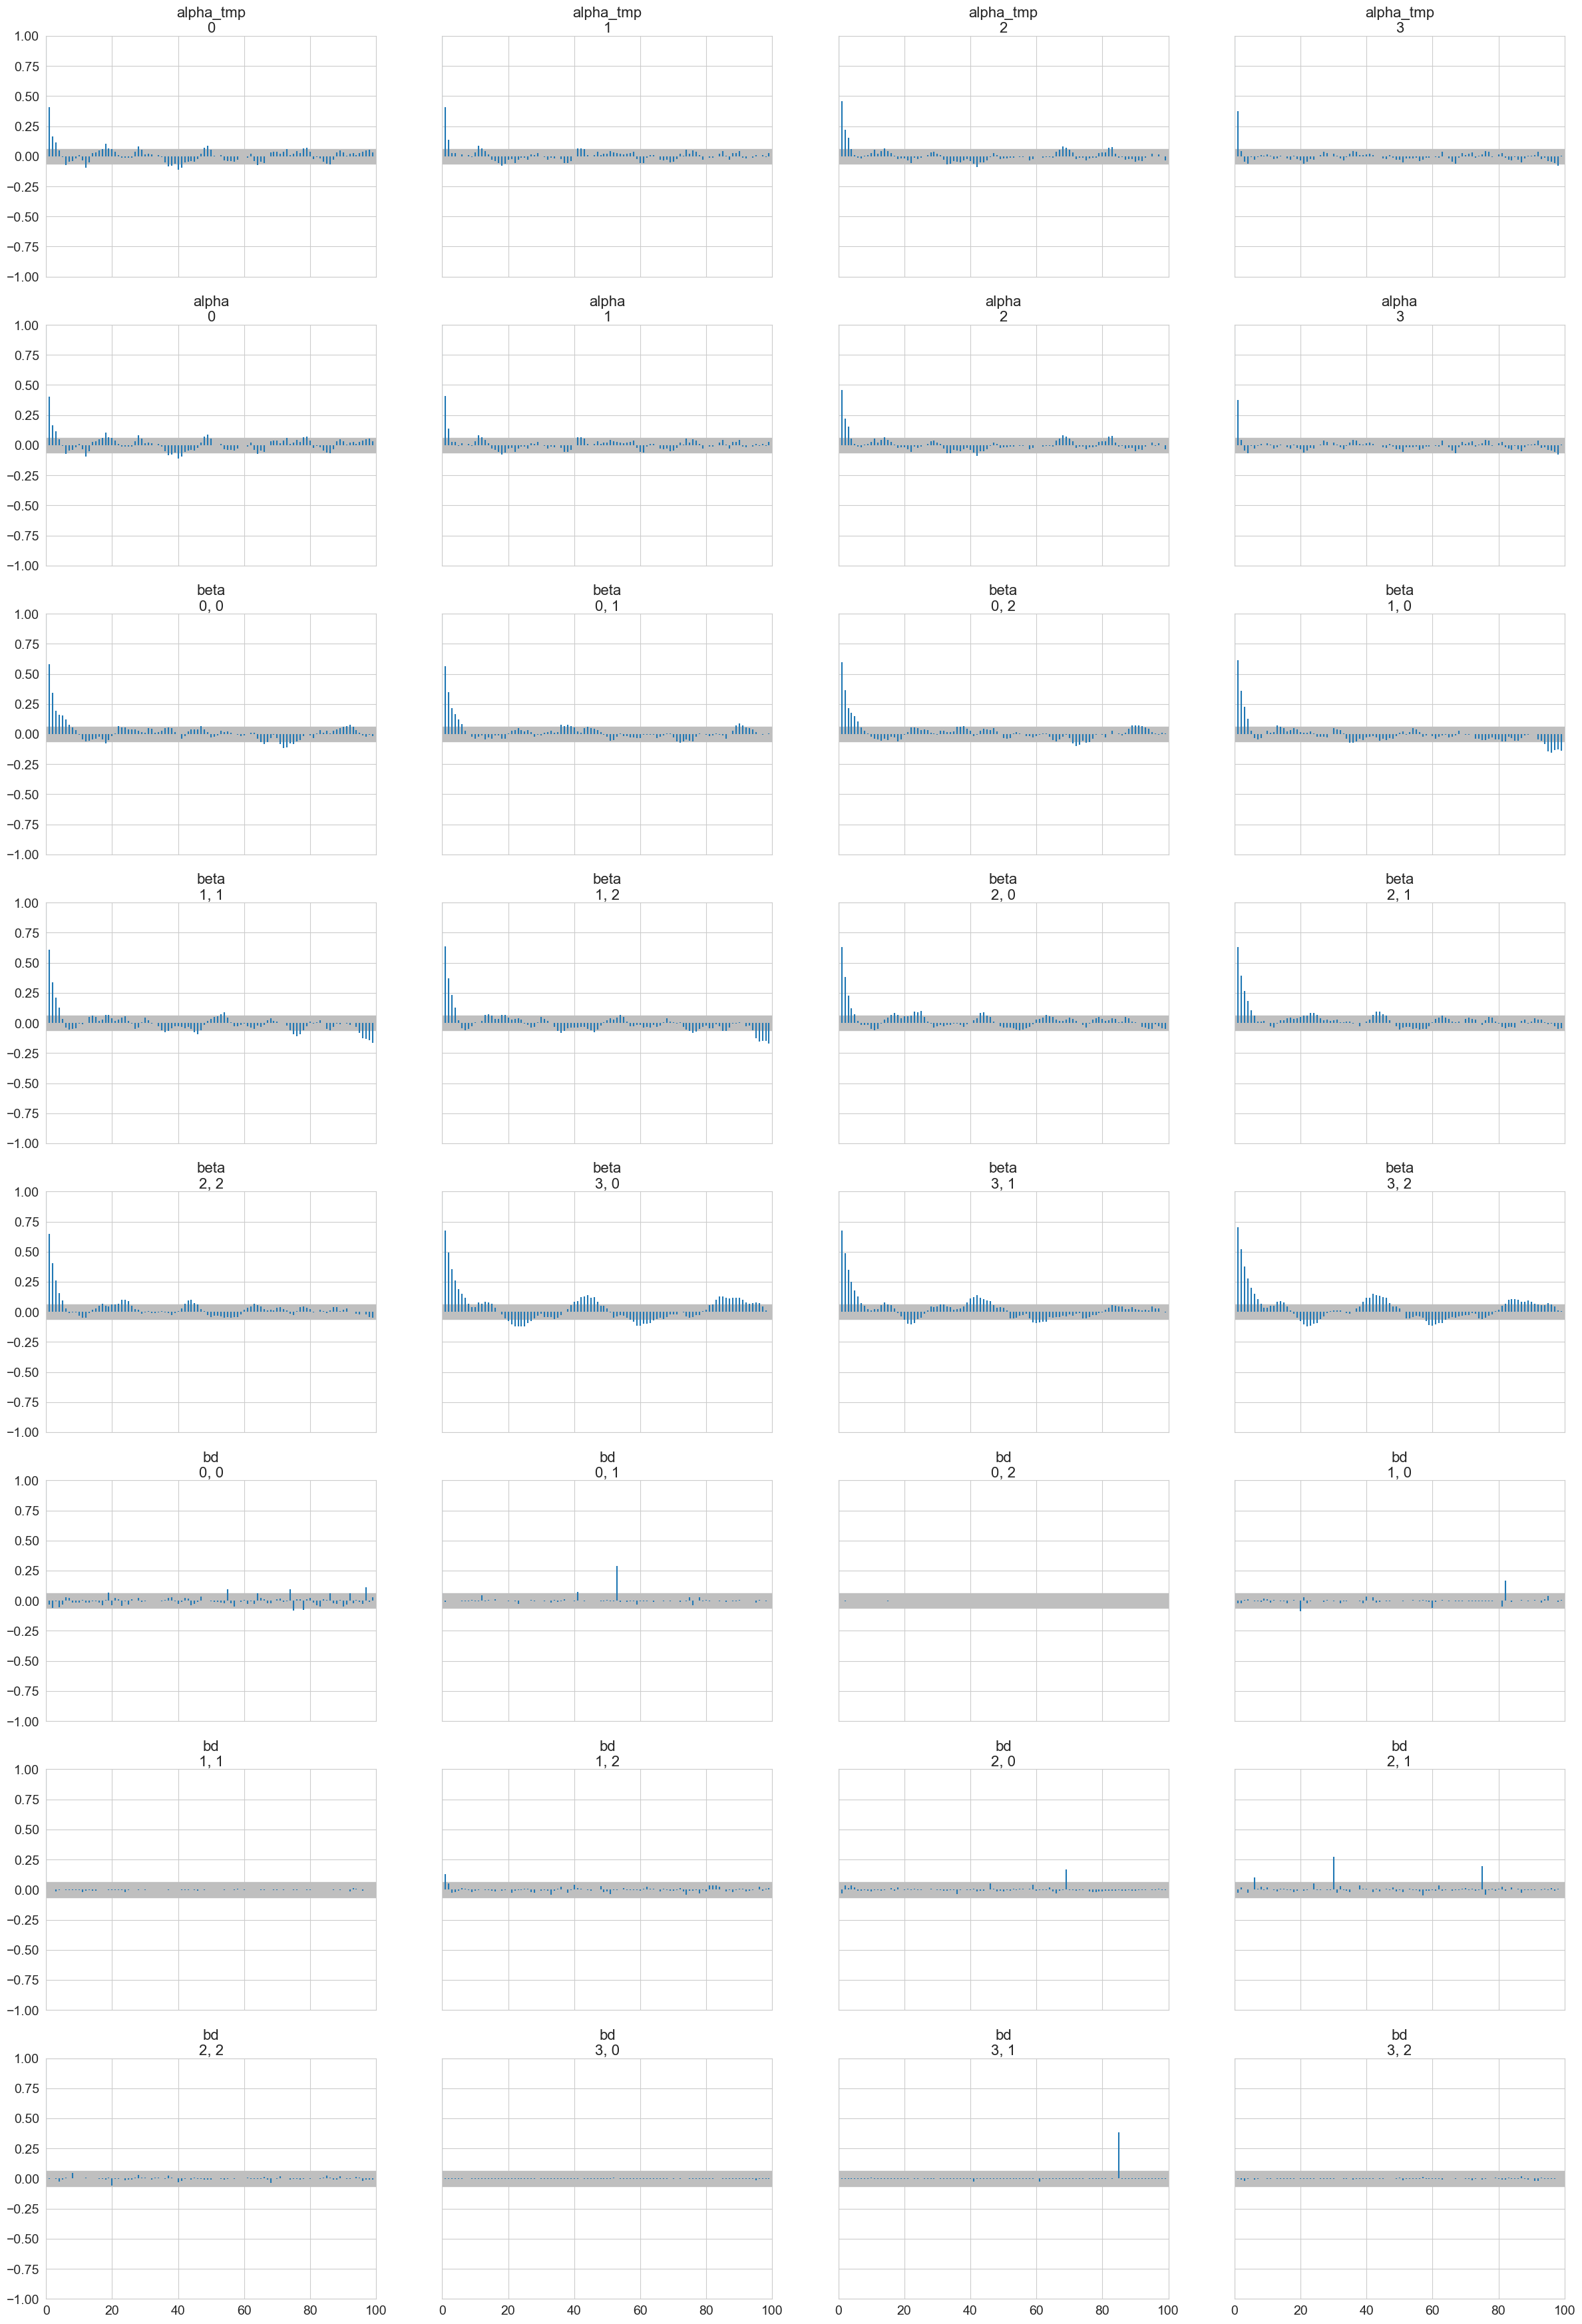

In [15]:
az.plot_autocorr(trace_1, ['alpha_tmp','alpha', 'beta', 'bd']);

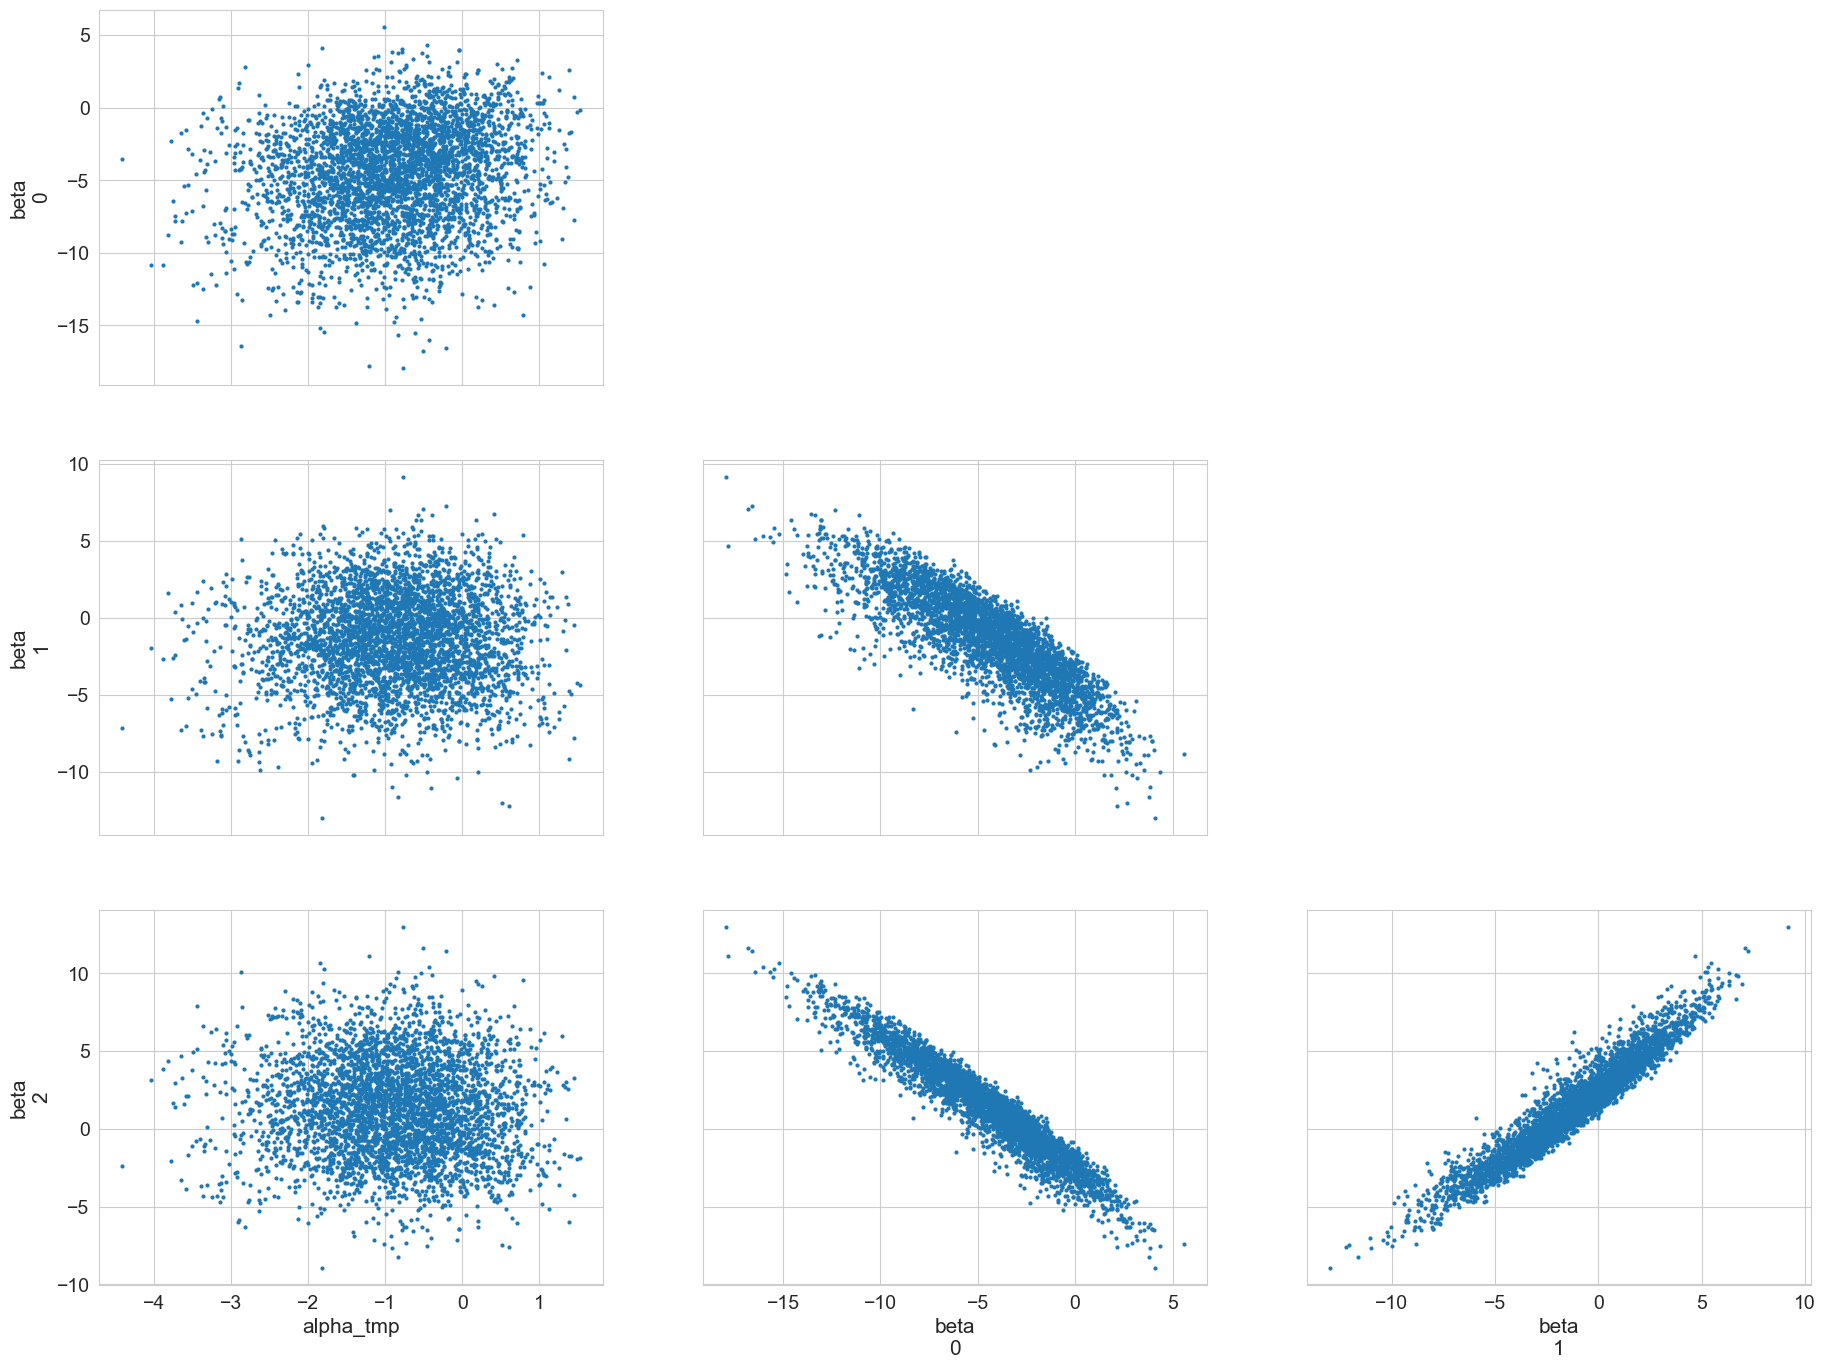

In [16]:
az.plot_pair(trace_1, var_names=['alpha_tmp', 'beta']);

In [17]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

In [18]:
with pm.Model() as model_2:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=20)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=3)

    mu = alpha_tmp + pm.math.dot(test_features_centered, beta)
    theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
    feature_mean = pm.math.dot(beta, test_features_centered.mean(axis=0))
    alpha = pm.Deterministic('alpha', alpha_tmp - feature_mean)
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('yl', p=theta)

    trace_2 = pm.sample(1000, tune=2000, chains=4, cores=4, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [alpha_tmp, beta]
>BinaryGibbsMetropolis: [yl]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
with model_2:
    ppc2 = pm.sample_posterior_predictive(trace_2, var_names=['yl'])

Sampling: [yl]


In [20]:
ppc2

Inference data with groups:
	> posterior_predictive